# Basic Normalizing Flow Training and Sampling

In [56]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random
using SpecialFunctions
using Distributions

import Flux.Optimise: ADAM, update!
Random.seed!(1234)

PyPlot.rc("font", family="serif"); 

In [57]:
# load earth model data
using JLD2, FileIO
@load "../compass_volume.jld2" X
println(size(X, 4))

1


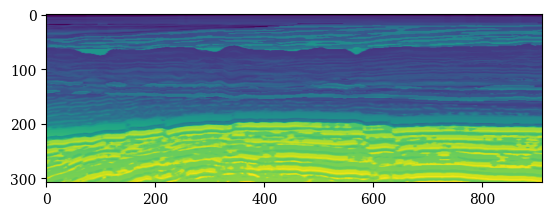

PyObject <matplotlib.image.AxesImage object at 0x2c26c8f40>

In [58]:
X0 = transpose(X[1000, :, :])
fig, ax = subplots(1, 1)
imshow(X0)

Use dataset from `ffjord`
```python
elif data == "8gaussians":
    scale = 4.
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
               (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                     1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []
    for i in range(batch_size):
        point = rng.randn(2) * 0.5
        idx = rng.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414
    return dataset
```

In [59]:
function generate_8gaussians(sample_size)
    scale = 4.
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / sqrt(2), 1. / sqrt(2)),
               (1. / sqrt(2), -1. / sqrt(2)), (-1. / sqrt(2), 1. / sqrt(2)), (-1. / sqrt(2), -1. / sqrt(2))]
    centers = [(scale * x, scale * y) for (x, y) in centers]
    dataset = []
    for i in 1:sample_size
        point = randn(2) * 0.5
        idx = rand(1:8)
        center = centers[idx]
        point[1] += center[1]
        point[2] += center[2]
        push!(dataset, point)
    end

    dataset = hcat(dataset...)
    dataset = convert(Array{Float32,2}, dataset) / 1.414
end

generate_8gaussians (generic function with 1 method)

In [60]:
data_name = "8gaussians"
flow = "tF"

if data_name == "banana"
    n_train = 60000;
    X_train = sample_banana(n_train);
    
    #training parameters
    batch_size = 50
    maxiter    = cld(n_train, batch_size)
    
elseif data_name == "sin"
    n_train = 60000;
    X1 = rand(Uniform(-5, 5), n_train)
    X2 = sin.(X1)   # sinusoidal data
    # X2 = 50 .* X1 .^ 2   # parabolic data
    X_train = zeros(1, 1, 2, n_train)
    X_train[1, 1, 1, :] = X1
    X_train[1, 1, 2, :] = X2
    
    #training parameters
    batch_size = 50
    maxiter    = cld(n_train, batch_size)
    
elseif data_name == "8gaussians"
    n_train = 1000000
    X_train = zeros(1, 1, 2, n_train)
    X_train[1, 1, :, :] = generate_8gaussians(n_train)
    
    batch_size = 2000
    maxiter    = 1000
end

1000

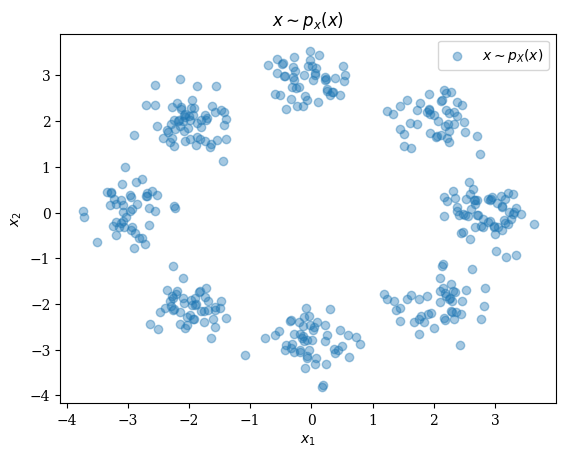

In [61]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

In [62]:
# function loss(G, X)
#     batch_size = size(X)[end] 
    
#     Z, lgdet = G.forward(X)
    
#     l2_loss = 0.5*norm(Z)^2 / batch_size  #likelihood under Normal Gaussian training 
#     dZ = Z / batch_size                   #gradient under Normal Gaussian training
    
#     G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
#     return (l2_loss, lgdet)
# end


function loss(G, X)
    batch_size = size(X)[end]
    
    Z, lgdet = G.forward(X)
    
    function l2_loss(Z)
        if flow == "NF"
            likelihood = -0.5*norm(Z)^2   # for sanity check. Recover normalizing flow result.
        elseif flow == "tF"
            cons = loggamma(0.5*(ν+d)) - loggamma(0.5*ν) - 0.5*d*log(pi*ν)
            likelihood = cons - 0.5*(ν + d) * log(1 + (1/ν) * norm(Z)^2)
        end
        
        return -likelihood / batch_size
    end
    
    # use AD
    θ = Flux.params([Z])
    back = Flux.Zygote.pullback(() -> l2_loss(Z), θ)[2]
    grad = back(1f0)
    logprob_grad = grad[θ[1]]
    
    G.backward(logprob_grad, Z)  # sets gradients of G wrt output and also logdet terms
    
    return (l2_loss(Z), lgdet, logprob_grad, Z)
end

loss (generic function with 1 method)

In [63]:
nx          = 1
ny          = 1

#network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 16
levels_L    = 1
flowsteps_K = 10
eps = 1

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;)
#G = G |> gpu 


lr = 9f-4
opt = ADAM(lr)

ν = 100
d = 2   # 2-d data throughout this notebook

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for ep in 1:eps
    for j = 1:maxiter
        Base.flush(Base.stdout)
        # idx = ((j-1)*batch_size+1):(j*batch_size)
        idx = rand(1:n_train, batch_size)

        X = X_train[:,:,:,idx]
        #x = x |> gpu

        losses = loss(G, X) #sets gradients of G

        loss_l2_list[j]    = losses[1]
        loss_lgdet_list[j] = losses[2]

        (j%50==0) && println("Iteration=", j, "/", maxiter,
                "; f l2 = ",   loss_l2_list[j], 
                "; f lgdet = ",loss_lgdet_list[j], 
                "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j])

        for p in get_params(G) 
            update!(opt,p.data,p.grad)
        end
    end
end

Iteration=50/1000; f l2 = 0.14604940349128293; f lgdet = -0.09819858977415064; f nll objective = 0.24424799326543356
Iteration=100/1000; f l2 = 0.27576613362011676; f lgdet = 3.673131998702265; f nll objective = -3.3973658650821483
Iteration=150/1000; f l2 = 0.352805127988956; f lgdet = 5.214302593676071; f nll objective = -4.861497465687115
Iteration=200/1000; f l2 = 0.3588155370180201; f lgdet = 5.9809598987124275; f nll objective = -5.622144361694407
Iteration=250/1000; f l2 = 0.38409531313307144; f lgdet = 6.58139232593015; f nll objective = -6.197297012797078
Iteration=300/1000; f l2 = 0.4046383855607444; f lgdet = 7.187363941526619; f nll objective = -6.782725555965874
Iteration=350/1000; f l2 = 0.40305546939119774; f lgdet = 7.739272798398073; f nll objective = -7.336217329006875
Iteration=400/1000; f l2 = 0.4316934715544504; f lgdet = 8.250194102738309; f nll objective = -7.818500631183858
Iteration=450/1000; f l2 = 0.4449907214015856; f lgdet = 8.732848828938614; f nll objecti

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with [qq plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

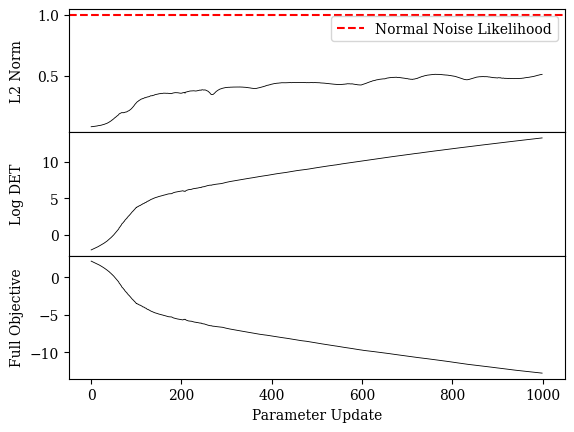

In [64]:
if flow == "tF"
    imgname = "flow=$flow" * "_ν=$ν" * "_data=$data_name" * "_batch_size=$batch_size" * "_itr=$maxiter" * "_eps=$eps"
elseif flow == "NF"
    imgname = "flow=$flow" * "_data=$data_name" * "_batch_size=$batch_size" * "_itr=$maxiter" * "_eps=$eps"
end

gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update")

savename = "training_curves_" * imgname * ".png"
savefig("07_plots/$savename")

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ in the simple 2D Rosenbrock distribution, we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$.

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Let's start by taking samples from $z \sim N(0,I) $

t-distribution sampling from paper:

```python
def _sample(self, num_samples):
    d = self._shape[0]
    x = np.random.chisquare(self._nu, num_samples)/self._nu
    x = np.tile(x[:,None], (1,d))
    x = torch.Tensor(x.astype(np.float32))
    z = torch.randn(num_samples, *self._shape)
    return (z/torch.sqrt(x))
```

In [65]:
## sample data from a base distribution

num_test_samples = 500;

if flow == "NF"
    Z_test = randn(Float32, nx, ny, n_in, num_test_samples);
elseif flow == "tF"
    # t_dist = TDist(ν)
    # Z_test = rand(t_dist, nx, ny, n_in, num_test_samples)
    
    # method 2: following Alexanderson 2020 manually make t distribution data
    x = rand(Chisq(ν), nx, ny, n_in, num_test_samples) ./ ν
    Z_test = randn(nx, ny, n_in, num_test_samples) ./ sqrt.(x)
end

println(size(X_train)) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 1000000)


In [66]:
x0 = rand(Chisq(ν), nx, ny, n_in, num_test_samples) ./ ν;
size(x0)

(1, 1, 2, 500)

In [67]:
@which repeat

Base

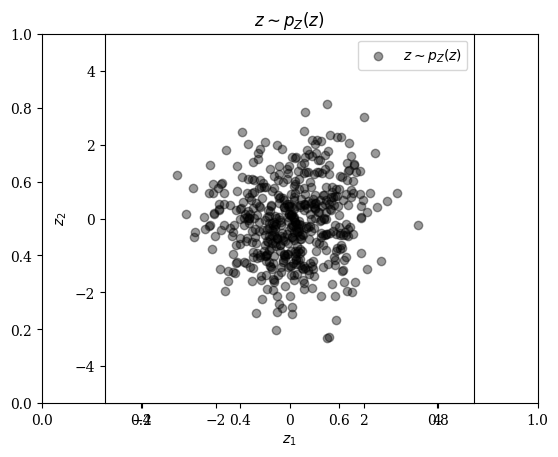

In [68]:
fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [69]:
X_test = G.inverse(Z_test);

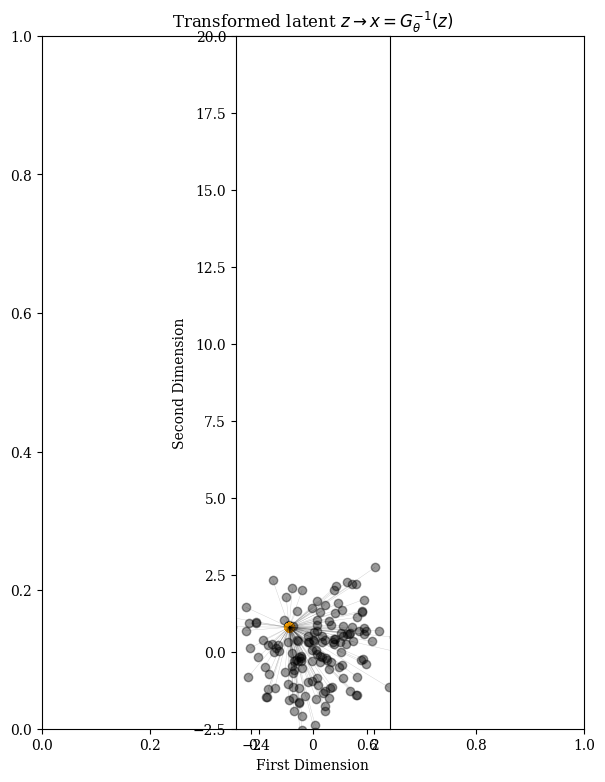

In [70]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

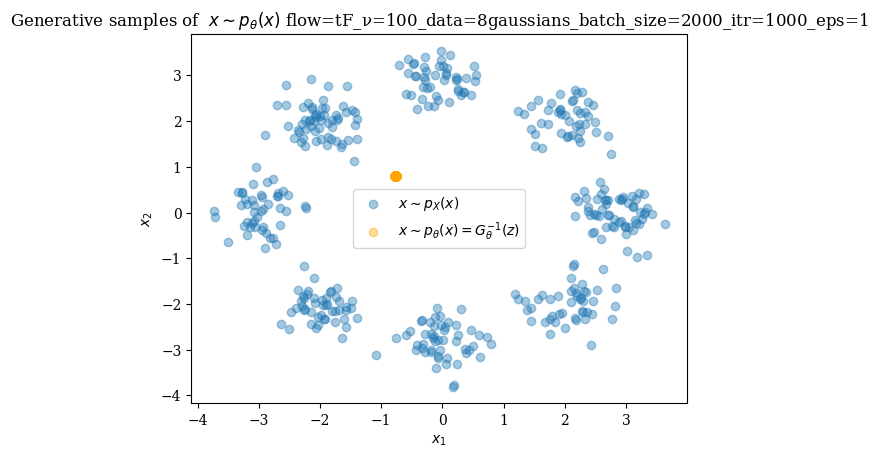

"G-1_samples_flow=tF_ν=100_data=8gaussians_batch_size=2000_itr=1000_eps=1.png"

In [71]:
fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$ " * imgname)
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-4,4); ylim(0,30);
legend();

savename = "G-1_samples_" * imgname * ".png"
# savefig("07_plots/$savename")

Below are a list of publications in SLIM group that use [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl) for seismic/medical imaging, and in general, inverse problems:

[Rafael Orozco, Mathias Louboutin, Felix J. Herrmann. Memory Efficient Invertible Neural Networks for 3D Photoacoustic Imaging. 2022.](https://slim.gatech.edu/Publications/Public/Submitted/2022/orozco2022MIDLmei/midl_2022.html)

[Siahkoohi, Ali, et al. "Wave-equation-based inversion with amortized variational Bayesian inference." arXiv preprint arXiv:2203.15881 (2022).](https://arxiv.org/abs/2203.15881)

[Orozco, Rafael, et al. "Photoacoustic imaging with conditional priors from normalizing flows." NeurIPS 2021 Workshop on Deep Learning and Inverse Problems. 2021.](https://openreview.net/pdf?id=woi1OTvROO1)

[Kumar, Rajiv, et al. "Enabling uncertainty quantification for seismic data preprocessing using normalizing flows (NF)—An interpolation example." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3583705.1)

[Siahkoohi, Ali, and Felix J. Herrmann. "Learning by example: fast reliability-aware seismic imaging with normalizing flows." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3581836.1)